# Running with 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import yaml
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print('GPU devices available:', tf.config.list_physical_devices('GPU'))

from scipy import io
import braincoder
from braincoder.utils.visualize import *
import prfpy_csenf

from os.path import join as opj
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel
from braincoder.stimuli import ContrastSensitivityStimulus
from braincoder.bprf_mcmc import BPRF
from braincoder.optimize import ParameterFitter
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-02-06 10:40:52.647021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 10:40:52.647107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 10:40:52.647121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 10:40:52.658079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/daghlian/.conda/envs/braincoder_b/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
sim_file = './output'
with open(opj(sim_file,'ground_truth.pkl'), 'rb') as file:
    gt = pickle.load(file)
    bounds = gt['bounds']
    data = gt['data']
    parameters = gt['parameters']
with open(opj(sim_file,'cfitter.pkl'), 'rb') as file:
    cf = pickle.load(file)
    cfitter = cf['cfitter']
    cfit_time = cf['cfit_time']
refined_pars = cfitter.estimated_parameters
model = cfitter.model    
with open(opj(sim_file,'bfitter.pkl'), 'rb') as file:
    bf = pickle.load(file)
    bfitter = bf['bfitter']
    bfit_time = bf['bfit_time']
print(cfit_time)
print(bfit_time)

Elapsed time - classical fitting: 0h 0m 18.45s
Elapsed time - MCMC fitting: 0h 2m 0.60s 


(214, 100)

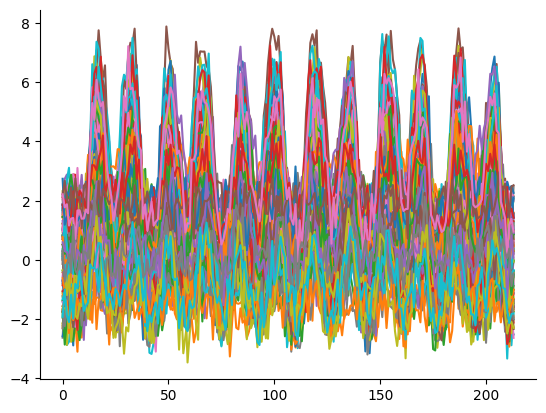

In [78]:
data.plot(legend=False)
sns.despine()
data.shape

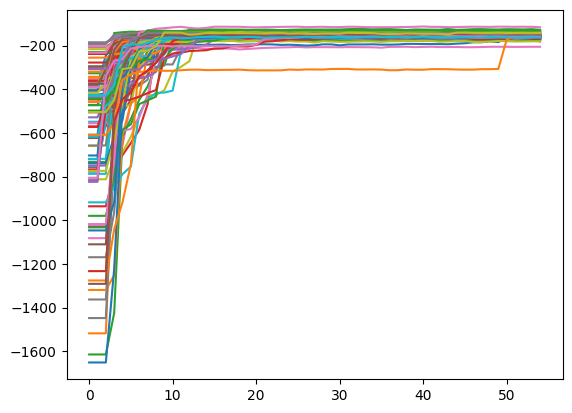

In [79]:
plt.plot(bfitter.mcmc_stats['log_prob'])

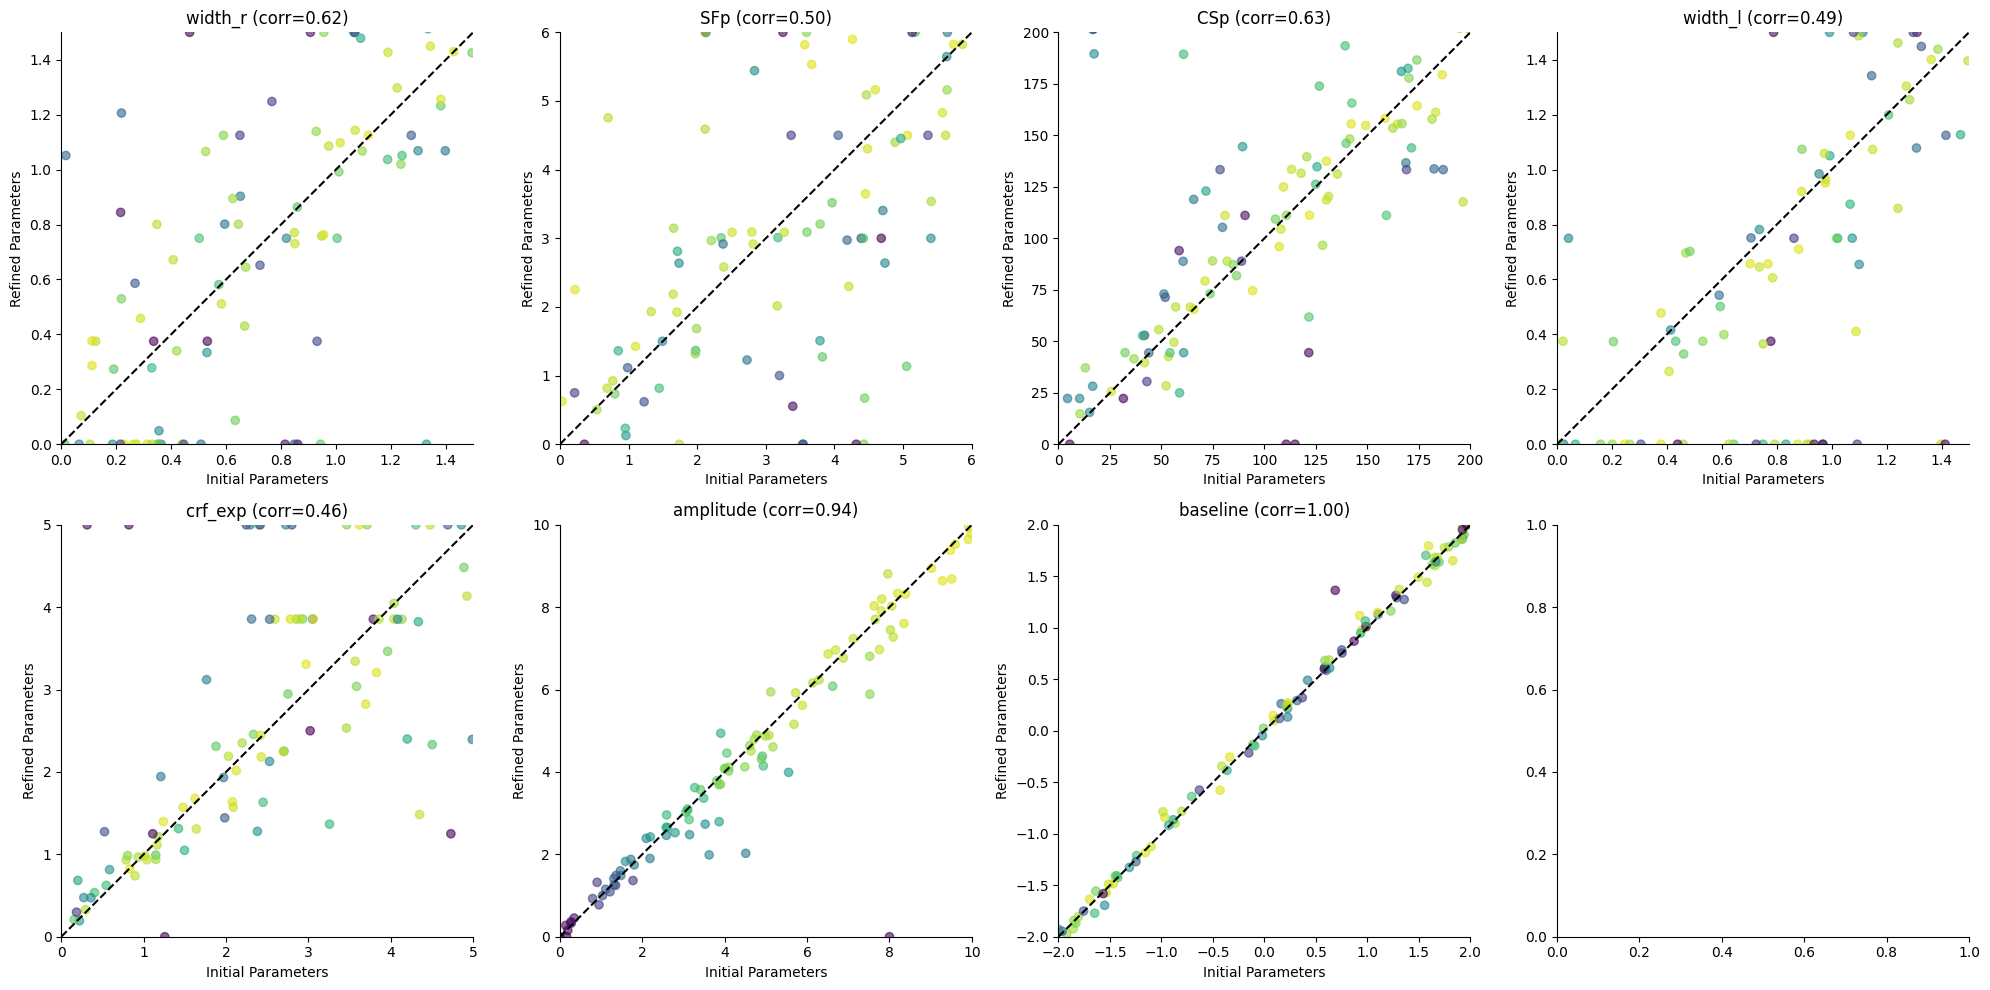

In [80]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
rsq = cfitter.get_rsq(parameters=refined_pars)
for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        c=rsq, 
        alpha=0.6,
        # cmap='viridis',
        vmin=0, vmax=1,
        )
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')
    sns.despine()

plt.tight_layout()
plt.show()

dict_keys(['log_prob', 'diverging', 'is_accepted', 'accept_ratio', 'leapfrogs_taken', 'step_size', 'elapsed_time'])


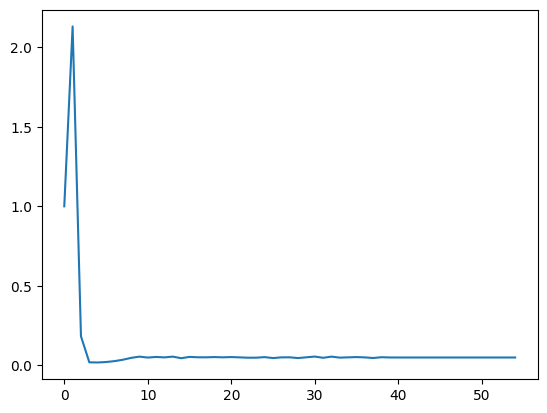

In [81]:
print(bfitter.mcmc_stats.keys())
plt.plot(bfitter.mcmc_stats['step_size'].numpy())



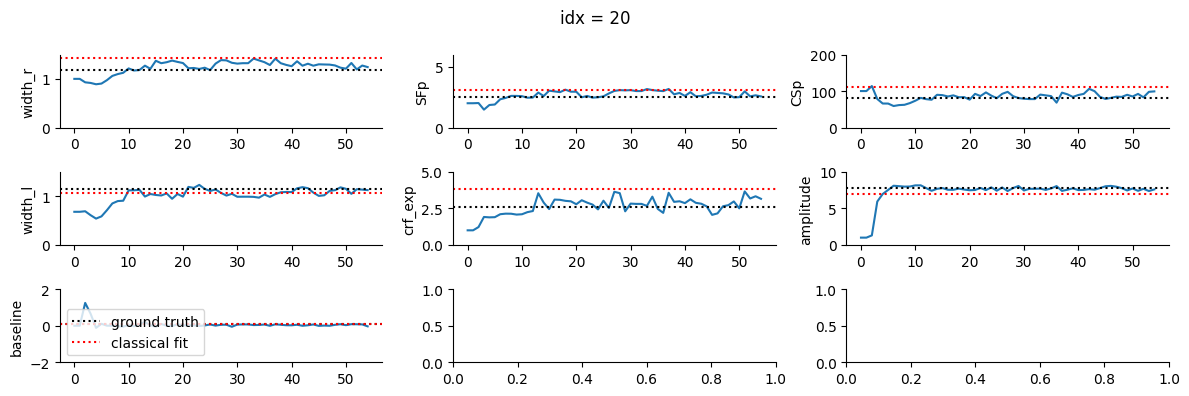

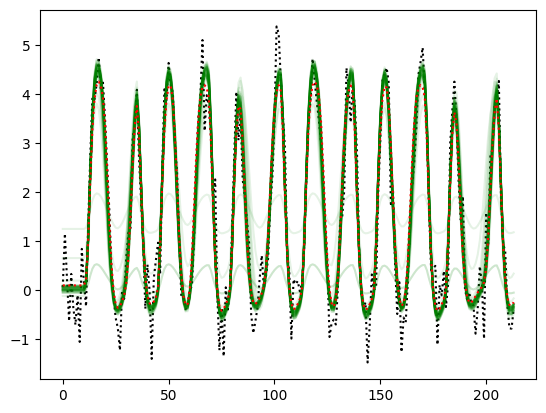

In [85]:
idx = 20
fig, axs = plt.subplots(3,3, figsize=(12,4))
fig.suptitle(f'idx = {idx}')
axs = axs.flatten()
for i,p in enumerate(bfitter.model_labels):    
    axs[i].plot(
        bfitter.mcmc_sampler[idx][p]
    )
    axs[i].axhline(parameters[p][idx], linestyle=':', color='k', label='ground truth')
    axs[i].axhline(refined_pars[p][idx] , linestyle=':', color='r', label='classical fit')
    axs[i].set_ylabel(p)
    axs[i].set_ylim(bounds[p])
    sns.despine()

axs[i].legend()
fig.set_tight_layout('tight')
plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=0.1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

In [86]:
idx = 0
burn_in = 100
this_mcmc_pars = bfitter.mcmc_sampler[idx].iloc[burn_in:,:]
rsq = bfitter.get_rsq_for_idx(idx=idx, parameters=this_mcmc_pars)
bloop
sns_plot = sns.pairplot(
    bfitter.sampler[idx].iloc[burn_in:,:],
    # plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

ValueError: in user code:

    File "/data1/projects/dumoulinlab/Lab_members/Marcus/programs/braincoder_bprf/braincoder/models.py", line 637, in _predict  *
        standardized_parameters = tf.tensor_scatter_nd_update(standardized_parameters, indices_baseline, updates_baseline)

    ValueError: Dimensions [0,3) of input[shape=[1,0,7]] = [1,0,7] must match dimensions [0,1) of updates[shape=[0]] = [0]: Shapes must be equal rank, but are 3 and 1 for '{{node TensorScatterUpdate}} = TensorScatterUpdate[T=DT_FLOAT, Tindices=DT_INT32](Identity, Const, zeros)' with input shapes: [1,0,7], [0], [0].


In [ ]:
bfitter.mcmc_sampler[idx]

(55, 7)

In [87]:
this_mcmc_pars

,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
